# ACTL3143 Assignment: Heart Disease Prediction Using Deep Learning

By Sharon Zhou (z5310019)

## Table of contents
* [Introduction](#introduction)
* [Data Preparation](#datapreparation)
* [Exploratory Data Analysis](#eda)
* [Data Splitting](#datasplitting)
* [Benchmark Model: Logistic Regression](#benchmarkmodel)

## 1. Introduction <a class="anchor" id="introduction"></a>

This assignment will use past patient variables along with a target condition of having the presence or absence of heart disease to create a predictive model for future patients. This is a binary classification type problem with a "goal" field of 1 = presence and 0 = absence. 

This early draft will conduct exploratory data analysis to gain insights into the dataset, before fitting a logistic regression model as a baseline. Further improvements will be made through deep learning techniques.

### 1.1 Data Dictionary 

Information on the attributes in the dataset is contained below: 

* ``` age ```: the patient's age in years
* ``` sex ```: the patient's sex (1 = male, 0 = female)
* ``` cp ```: the chest pain experienced (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
* ``` trestbps ```: the patient's resting blood pressure in mm/Hg upon admission to the hospital
* ``` chol ```: the patient's cholesterol measurement in mg/dl
* ``` fbs ```: the patient's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
* ``` restecg ```: the patient's resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = left ventricular hypertrophy)
* ``` thalach ```: the patient's maximum heart rate achieved
* ``` exang ```: exercise-induced angina
* ``` oldpeak ```: the patient's ST depression induced by exercise relative to rest
* ``` slope ```: the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
* ``` ca ```: the number of major vessels (0-3) coloured by flouroscopy
* ``` thal ```: displays the thalassemia (3 = normal, 6 = fixed defect, 7 = reversible defect)
* ``` target ```: the patient's diagnosis of heart disease (0 = absence; 1-4 = presence)

## 2. Data Preparation <a class="anchor" id="datapreparation"></a>

### 2.1 Loading all packages 

In [30]:
from pathlib import Path
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random

from sklearn import set_config, metrics
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Reshape, Concatenate, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

set_config(transform_output="pandas")

### 2.2 Importing data 

The dataset used is from the University of California Irvine (UCI) data repository and contains data on 270 Cleveland patients with 13 independent predictive variables. The dataset was downloaded from the following website:
https://data.world/informatics-edu/heart-disease-prediction

In [31]:
#Importing the dataset

response = requests.get("https://raw.githubusercontent.com/sharonnnzhou/actl3143/main/assignment/Heart_Disease_Prediction.csv")

if response.status_code == 200:
    with open("Heart_Disease_Prediction.csv", "wb") as file:
        file.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print("Error downloading the dataset.")
    
df = pd.read_csv("Heart_Disease_Prediction.csv")

Dataset downloaded successfully.


### 2.3 Formatting data

To format our data for input into the model, we will first simplify the column names by providing col_names to the rename() function.

In [32]:
#Shortening column names 
col_names = ['age', 'sex', 'cp', 'trestbps', 'fbs', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df.rename(columns=dict(zip(df.columns, col_names)), inplace=True)

The pandas info() function allows us to check for null values and column types in the dataset. We define our categorical and numeric variables and change their types to string and integer accordingly.

In [33]:
#Information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       270 non-null    int64  
 1   sex       270 non-null    int64  
 2   cp        270 non-null    int64  
 3   trestbps  270 non-null    int64  
 4   fbs       270 non-null    int64  
 5   chol      270 non-null    int64  
 6   restecg   270 non-null    int64  
 7   thalach   270 non-null    int64  
 8   exang     270 non-null    int64  
 9   oldpeak   270 non-null    float64
 10  slope     270 non-null    int64  
 11  ca        270 non-null    int64  
 12  thal      270 non-null    int64  
 13  target    270 non-null    object 
dtypes: float64(1), int64(12), object(1)
memory usage: 29.7+ KB


In [34]:
#Converting target strings to boolen 

df['target'] = df['target'].replace(['Presence', 'Absence'], [1, 0])
target = ["target"]

In [35]:
#Defining categorical and numerical variables
categorical_variables = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
df[categorical_variables]=df[categorical_variables].astype("string")

numerical_variables = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
df[numerical_variables]=df[numerical_variables].astype("int")

Finally, we check for any potential dataset imbalances i.e., cases where the number of instances of heart disease is a very small proportion of the total dataset. Given that 120 out of 270 total observations are positive, there is minimal dataset imbalance.

In [36]:
#Checking for dataset imbalances
neg, pos = np.bincount(df['target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 270
    Positive: 120 (44.44% of total)



## 3. Exploratory Data Analysis <a class="anchor" id="eda"></a>

### 3.1 Descriptive Statistics


This section calculates summary statistics (e.g. mean, std, quantiles) for the numeric variables in the dataset. 

In [37]:
print(df.describe())

              age    trestbps        chol     thalach     oldpeak          ca  \
count  270.000000  270.000000  270.000000  270.000000  270.000000  270.000000   
mean    54.433333  131.344444    0.148148  149.677778    0.766667    0.670370   
std      9.109067   17.861608    0.355906   23.165717    1.053054    0.943896   
min     29.000000   94.000000    0.000000   71.000000    0.000000    0.000000   
25%     48.000000  120.000000    0.000000  133.000000    0.000000    0.000000   
50%     55.000000  130.000000    0.000000  153.500000    0.000000    0.000000   
75%     61.000000  140.000000    0.000000  166.000000    1.000000    1.000000   
max     77.000000  200.000000    1.000000  202.000000    6.000000    3.000000   

           target  
count  270.000000  
mean     0.444444  
std      0.497827  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000  


### 3.2 Correlation analysis

The correlation plot below illustrates the correlation coefficients between the numeric variables in the dataset. Here we can see that the target variable has a high negative correlation with "thalach" and high positive correlations with "oldpeak" and "ca". 

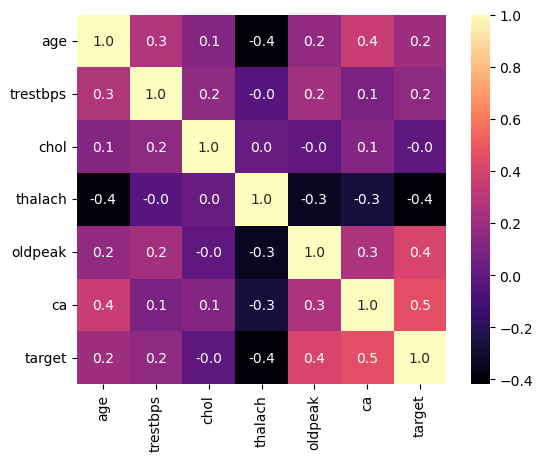

In [38]:
#Correlation plot
df_corr = df.corr(numeric_only=True).transpose()
sns.heatmap(df_corr,cbar=True,square=True, annot = True, fmt=".1f", cmap = "magma")
plt.show()

### 3.3 Univariate analysis 

The distribution graphs below have been plotted for all variables in the dataset to check for linearity of features. We can see that in general, the features are evenly distributed. However, there's an imbalance in "restecg", and "chol", "oldpeak" and "ca" are skewed towards 0.

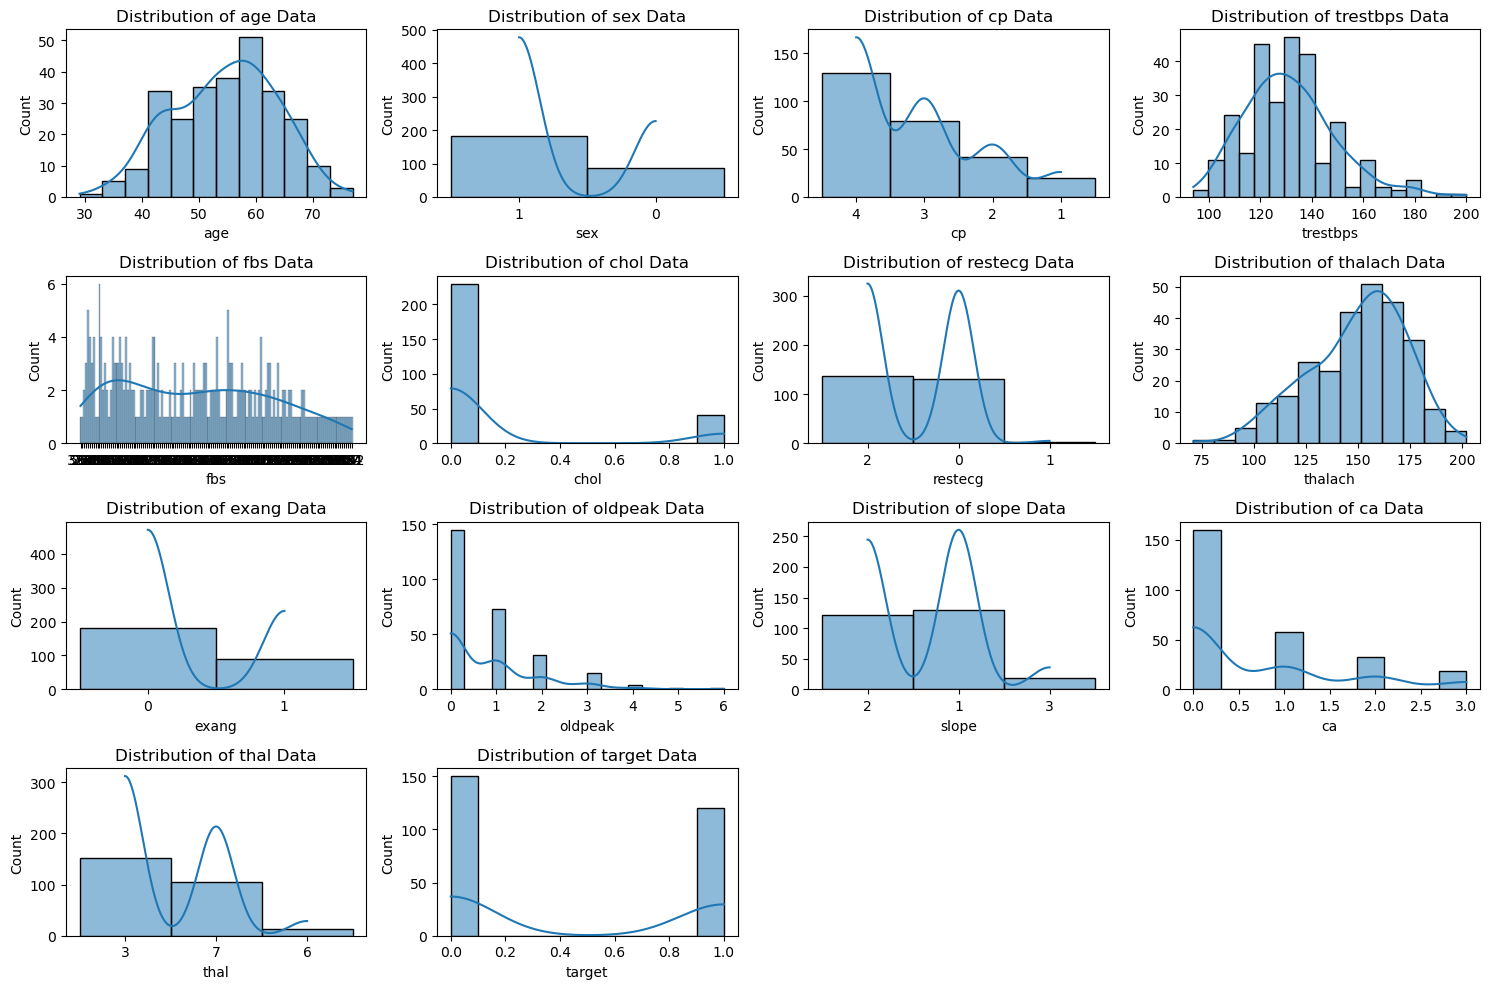

In [39]:
#Plotting univariate distribution graphs
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,4,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

### 3.4 Bivariate analysis - numerical

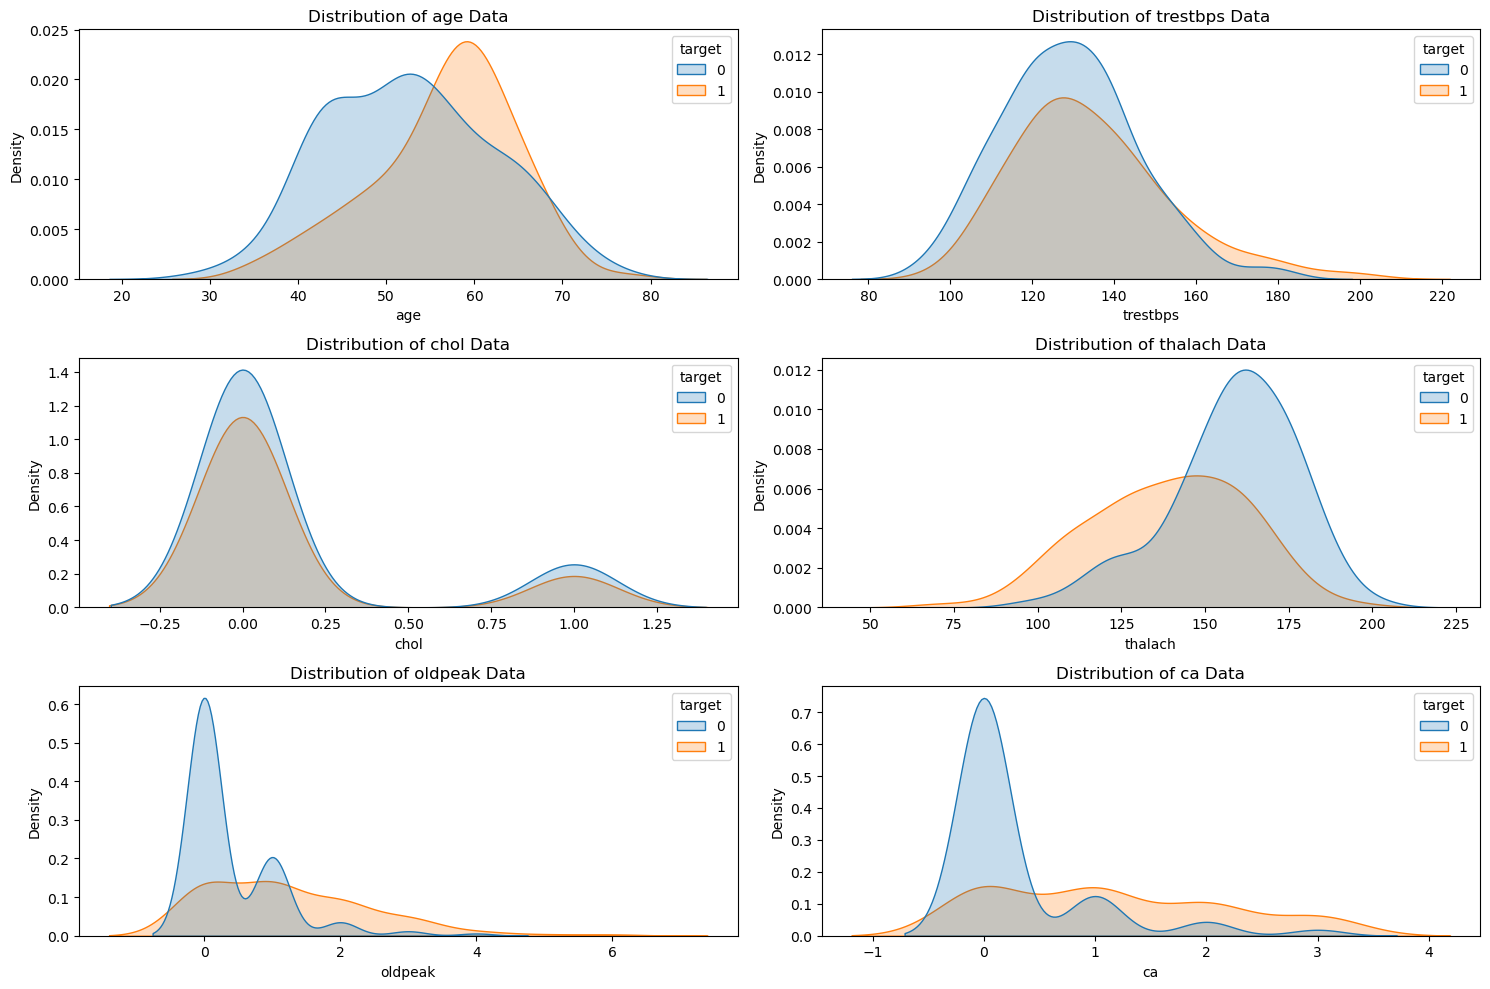

In [40]:
#Distribution of numerical variables according to the target variable

plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_variables,1):
    plt.subplot(3,2,i)
    plt.title(f"Distribution of {col} Data")
    sns.kdeplot(data=df, x = col, hue = "target", fill = True)
    plt.tight_layout()
    plt.plot()

### 3.5 Bivariate analysis - categorical

In [41]:
#Heart attack distribution according to categorical variables
%matplotlib inline
plt.figure(figsize=(15,10))

for variable in categorical_variables:
    fig = px.histogram(df, x="target", color=variable, hover_data=df.columns, title=f"Distribution of Heart Disease against {variable}", barmode="group")
    fig.show()

<Figure size 1500x1000 with 0 Axes>

### 3.6 Further exploration 

In [42]:
# Create a box plot
%matplotlib inline
px.box(data_frame = df, x='target', y='age', 
       color = "target", title = "Figure 3: Boxplot of Age vs. Target")


<Axes: xlabel='ca', ylabel='age'>

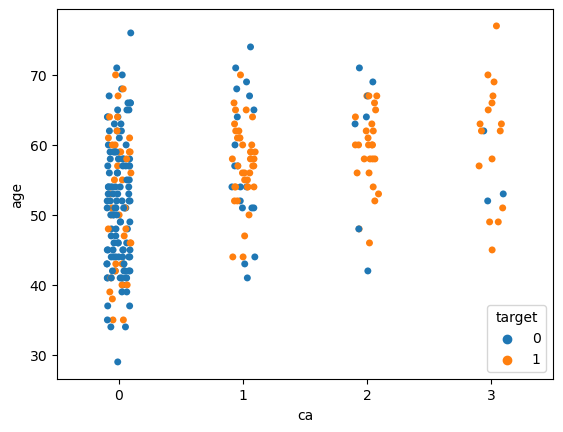

In [43]:
#Heart attack distribution according to age and the number of major vessels
sns.stripplot(data=df,x='ca',y='age',hue='target')

## 4. Data splitting <a class="anchor" id="datasplitting"></a>

The data is then split into a 60% training, 20% validation and 20% test set. 

In [44]:
# Creating a copy of the dataset
df1 = df

# Defining the columns to be encoded and scaled
cat_cols = ['sex','exang','cp','fbs','restecg','slope','thal', 'ca']
con_cols = ["age","trestbps","chol","thalach","oldpeak"]

# Encoding the categorical columns
df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

# Defining the features and target
target = df1["target"]
features = df1.drop("target",axis=1)

# Scaling the continuous variables
scaler = RobustScaler()
features[con_cols] = scaler.fit_transform(features[con_cols])

In [45]:
#Splitting the data into training, validation and test sets.
X_main, X_test, y_main, y_test = train_test_split(
    features, target, test_size=0.2, random_state = 2023
)

X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size=0.25, random_state = 2023
)

X_train.shape, X_val.shape, X_test.shape

((162, 162), (54, 162), (54, 162))

## 5. Benchmark Model <a class="anchor" id="benchmarkmodel"></a>

### 5.1 Logistic Regression

Our task is to solve a binary classification problem of predicting whether a patient has the presence or absence of heart disease. Logistic regression is a simple yet powerful machine learning algorithm that is a special case of linear regression. Namely, the model predicts the probability of an observation belonging to either binary class using a logit function. A linear regression equation is shown below, where y is the target variable and X1, X2 ... and X13 are the explanatory variables:

$$ y = \beta_0 + \beta_1X_1 + ... + \beta_{13}X_{13} $$

It does this by fitting a sigmoid curve to the observations from the training set. The curve is 'S' shaped and maps any real-valued number to a value between 0 and 1. The following equation shows the sigmoid function:

$$ \sigma(x) = {1\over 1+\exp(-y)} $$

In [46]:
#Creating a logistic regression model 

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred = np.argmax(logreg.predict_proba(X_test),axis=1)

print("The test accuracy score of Logistic Regression is ", accuracy_score(y_test, y_pred))

The test accuracy score of Logistic Regression is  0.8703703703703703


### 5.2 Model Evaluation

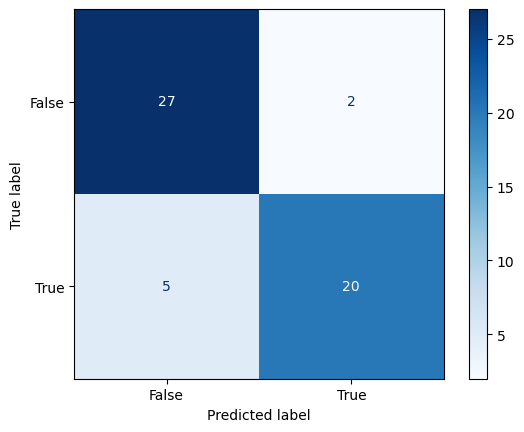

In [47]:
#Plotting a confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = [False, True])

cm_display.plot(cmap = "Blues")
plt.show()

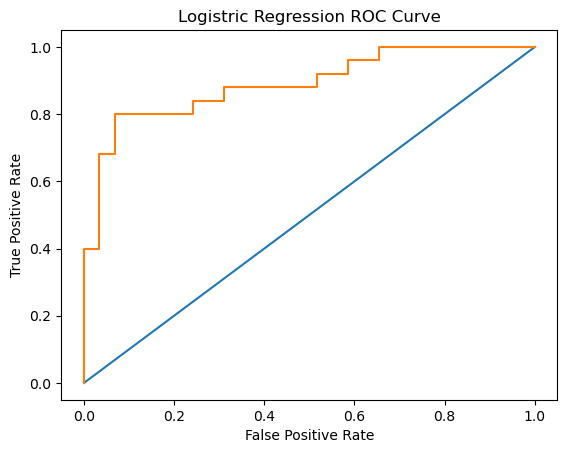

The AUC-ROC of the Logistic Regression is  0.8896551724137931


In [48]:
#Plotting the ROC Curve

y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr,tpr,threshols=roc_curve(y_test,y_pred_prob)
auc_roc = roc_auc_score(y_test, y_pred_prob)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistric Regression ROC Curve")
plt.show()
print("The AUC-ROC of the Logistic Regression is ", auc_roc)

In [49]:
#Running the classification report
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.91      0.80      0.85        25

    accuracy                           0.87        54
   macro avg       0.88      0.87      0.87        54
weighted avg       0.87      0.87      0.87        54

